# Using Siphon to get NEXRAD Level 2 data from a TDS

### Objectives:
1. Learn more about Siphon
2. Use the RadarServer class to retrieve radar data from a TDS
3. Plot this data using numpy arrays and matplotlib

In this example, we'll focus on interacting with the Radar Query Service to retrieve radar data.

**But first!**
Bookmark these resources for when you want to use Siphon later!
+ [latest Siphon documentation](http://siphon.readthedocs.org/en/latest/)
+ [Siphon github repo](https://github.com/Unidata/siphon)
+ [TDS documentation](http://www.unidata.ucar.edu/software/thredds/v4.6/tds/TDS.html)

## Querying the server

First, we point at the top level of the Radar Query Service (the "Radar Server") to see what radar collections are available:

In [3]:
from siphon.catalog import TDSCatalog
cat = TDSCatalog('http://thredds-aws.unidata.ucar.edu/thredds/radarServer/catalog.xml')
list(cat.catalog_refs)

['S3 NEXRAD Level II']

Next we create an instance of the `RadarServer` object to point at one of these collections. This downloads some top level metadata and sets things up so we can easily query the server.

In [4]:
from siphon.radarserver import RadarServer
rs = RadarServer(cat.catalog_refs['S3 NEXRAD Level II'].href)

We can use rs.variables to see a list of radar products available to view from this access URL.

In [5]:
print(sorted(rs.variables))

['CorrelationCoefficient', 'DifferentialPhase', 'DifferentialReflectivity', 'Reflectivity', 'SpectrumWidth', 'Velocity']


We can also see a list of the stations. Each station has associated location information.

In [7]:
print(sorted(rs.stations))

['KABC', 'KABR', 'KABX', 'KACG', 'KAEC', 'KAHG', 'KAIH', 'KAKC', 'KAKQ', 'KAMA', 'KAMX', 'KAPD', 'KAPX', 'KARX', 'KATX', 'KBBX', 'KBGM', 'KBHX', 'KBIS', 'KBLX', 'KBMX', 'KBOX', 'KBRO', 'KBUF', 'KBYX', 'KCAE', 'KCBW', 'KCBX', 'KCCX', 'KCLE', 'KCLX', 'KCRI', 'KCRP', 'KCXX', 'KCYS', 'KDAX', 'KDDC', 'KDFX', 'KDGX', 'KDIX', 'KDLH', 'KDMX', 'KDOX', 'KDTX', 'KDVN', 'KDYX', 'KEAX', 'KEMX', 'KENX', 'KEOX', 'KEPZ', 'KESX', 'KEVX', 'KEWX', 'KEYX', 'KFCX', 'KFDR', 'KFDX', 'KFFC', 'KFSD', 'KFSX', 'KFTG', 'KFWS', 'KGGW', 'KGJX', 'KGLD', 'KGRB', 'KGRK', 'KGRR', 'KGSP', 'KGUA', 'KGWX', 'KGYX', 'KHDX', 'KHGX', 'KHKI', 'KHKM', 'KHMO', 'KHNX', 'KHPX', 'KHTX', 'KHWA', 'KICT', 'KICX', 'KILN', 'KILX', 'KIND', 'KINX', 'KIWA', 'KIWX', 'KJAN', 'KJAX', 'KJGX', 'KJKL', 'KJUA', 'KLBB', 'KLCH', 'KLIX', 'KLNX', 'KLOT', 'KLRX', 'KLSX', 'KLTX', 'KLVX', 'KLWX', 'KLZK', 'KMAF', 'KMAX', 'KMBX', 'KMHX', 'KMKX', 'KMLB', 'KMOB', 'KMPX', 'KMQT', 'KMRX', 'KMSX', 'KMTX', 'KMUX', 'KMVX', 'KMXX', 'KNKX', 'KNQA', 'KOAX', 'KOHX',

In [9]:
rs.stations['KTLX']

Station(id='KTLX', elevation=370.0, latitude=35.32, longitude=-97.27, name='OKLAHOMA_CITY/Norman')

Next, we'll create a new query object to help request the data. Using the chaining methods, let's ask for the volume from radar TLX (Oklahoma City) for the current time. We see that when the query is represented as a string, it shows the encoded URL.

In [14]:
from datetime import datetime
query = rs.query()
query.stations('KTLX').time(datetime.utcnow())

time=2017-01-20T00%3A36%3A17.673135&stn=KTLX

The query also supports time range queries, queries for closest to a lon/lat point, or getting all radars within a lon/lat box.

We can use the RadarServer instance to check our query, to make sure we have required parameters and that we have chosen valid station(s) and variable(s).

In [15]:
rs.validate_query(query)

True

Make the request, which returns an instance of TDSCatalog. This handles parsing the catalog

In [16]:
catalog = rs.get_catalog(query)

We can look at the datasets on the catalog to see what data we found by the query. We find one volume file in the return

In [18]:
catalog.datasets

OrderedDict([('KTLX20170120_002451_V06',
              <siphon.catalog.Dataset at 0x10f6ed128>)])

### Exercise: Querying the radar server

We'll work through doing some more queries on the radar server. Some useful links:
- RadarQuery [documentation](https://siphon.readthedocs.org/en/latest/api/radarserver.html#siphon.radarserver.RadarQuery)
- Documentation on Python's [datetime.timedelta](https://docs.python.org/3.5/library/datetime.html#timedelta-objects)

See if you can write Python code for the following queries:

Get the volume for 3 days ago from the radar nearest to Hays, KS (lon -99.324403, lat 38.874929). **No map necessary!**

Get the volumes the last two hours from all of the radars in Wyoming (call it the bounding box with lower left corner 41.008717, -111.056360 and upper right corner 44.981008, -104.042719)

## Pulling out the data

We can pull that dataset out of the dictionary and look at the available access URLs. We see URLs for OPeNDAP, CDMRemote, and HTTPServer (direct download).

In [19]:
ds = list(catalog.datasets.values())[0]
ds.access_urls

{'CdmRemote': 'http://thredds-aws.unidata.ucar.edu/thredds/cdmremote/nexrad/level2/S3/2017/01/20/KTLX/KTLX20170120_002451_V06',
 'HTTPServer': 'http://thredds-aws.unidata.ucar.edu/thredds/fileServer/nexrad/level2/S3/2017/01/20/KTLX/KTLX20170120_002451_V06',
 'OPENDAP': 'http://thredds-aws.unidata.ucar.edu/thredds/dodsC/nexrad/level2/S3/2017/01/20/KTLX/KTLX20170120_002451_V06'}

We need the OPENDAP link to feed to pyart:

We pull out the variables we need for azimuth and range, as well as the data itself.

In [26]:
import matplotlib.pyplot as plt
import pyart
%matplotlib inline

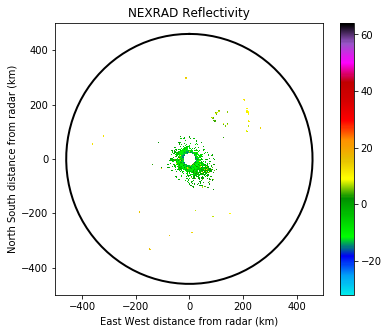

In [27]:
radar = pyart.io.read_nexrad_cdm(ds.access_urls['OPENDAP'])
display = pyart.graph.RadarDisplay(radar)
fig = plt.figure(figsize=(6, 5))

# plot super resolution reflectivity
ax = fig.add_subplot(111)
display.plot('reflectivity', 0, title='NEXRAD Reflectivity',
             vmin=-32, vmax=64, colorbar_label='', ax=ax)
display.plot_range_ring(radar.range['data'][-1]/1000., ax=ax)
display.set_limits(xlim=(-500, 500), ylim=(-500, 500), ax=ax)

### Exercise: Your turn to plot!

Try making your own plot of radar data. Various options here, but this is pretty open-ended. Some options to inspire you:
- Try plotting velocity instead of reflectivity
- Grab another radar
- Multiple radars?
